테스트셋 준비 완료: (500, 24) (500,)
====== Baseline ======
Accuracy : 0.986
Precision: 0.9959183673469387
Recall   : 0.976
F1Score  : 0.9858585858585859

====== Finetuned ======
Accuracy : 0.974
Precision: 0.9721115537848606
Recall   : 0.976
F1Score  : 0.9740518962075848

두 모델이 다르게 예측한 개수: 8


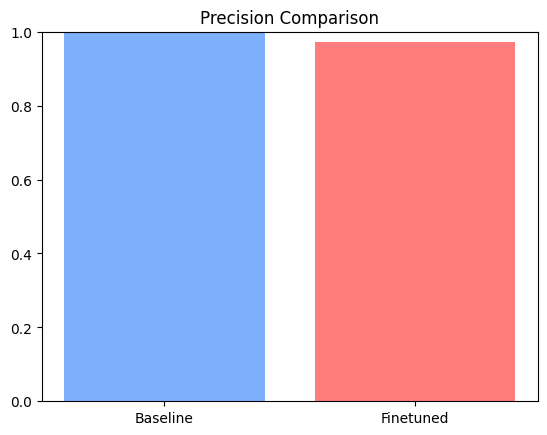

In [4]:
import os
import pandas as pd
import joblib
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 테스트 데이터 로드
df_test_normal = pd.read_csv("data/processed/test/merged_normal_test.csv", index_col=0)
df_test_phish  = pd.read_csv("data/processed/test/merged_phishing_test.csv", index_col=0)

# 라벨링
df_test_normal["target"] = 0
df_test_phish["target"] = 1

# 합치기
df_test = pd.concat([df_test_normal, df_test_phish], ignore_index=True)

# 셔플
df_test = df_test.sample(frac=1, random_state=42).reset_index(drop=True)

# X_test, y_test 생성
X_test = df_test.drop(columns=["url", "target"])
y_test = df_test["target"]

print("테스트셋 준비 완료:", X_test.shape, y_test.shape)


import joblib
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 모델 로드
baseline = joblib.load("models/baseline.pkl")
finetuned = joblib.load("models/finetuned.pkl")

# 예측
baseline_pred = baseline.predict(X_test)
finetuned_pred = finetuned.predict(X_test)

# 함수
def evaluate(name, pred):
    print("======", name, "======")
    print("Accuracy :", accuracy_score(y_test, pred))
    print("Precision:", precision_score(y_test, pred))
    print("Recall   :", recall_score(y_test, pred))
    print("F1Score  :", f1_score(y_test, pred))
    print()

# 평가 출력
evaluate("Baseline", baseline_pred)
evaluate("Finetuned", finetuned_pred)


import pandas as pd

fi_base = pd.Series(baseline.feature_importances_, index=X_test.columns)
fi_ft   = pd.Series(finetuned.feature_importances_, index=X_test.columns)

df_fi = pd.DataFrame({
    "baseline": fi_base,
    "finetuned": fi_ft,
    "diff": fi_ft - fi_base
}).sort_values("diff", ascending=False)

df_fi.head(15)   # 변화가 큰 상위 15개 피처 확인


df_test["baseline_pred"] = baseline_pred
df_test["finetuned_pred"] = finetuned_pred

# 서로 다른 예측만 필터링
df_diff = df_test[df_test["baseline_pred"] != df_test["finetuned_pred"]]

print("두 모델이 다르게 예측한 개수:", len(df_diff))
df_diff[["url", "target", "baseline_pred", "finetuned_pred"]].head(20)


plt.bar(["Baseline", "Finetuned"], 
        [precision_score(y_test, baseline_pred),
         precision_score(y_test, finetuned_pred)],
        color=["#7dafff", "#ff7d7d"])

plt.title("Precision Comparison")
plt.ylim(0, 1)
plt.show()

